In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("assignment1_mlp_backprop.ipynb")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(42)

def generate_spiral_data(N=100, K=3):
    """
    Generates a spiral dataset for classification.

    Args:
        N: Number of points per class
        K: Number of classes
    Returns:
        X: Feature matrix (N*K, 2)
        y: Labels (N*K,)
    """
    D = 2 # Dimensionality
    X = np.zeros((N*K,D))
    y = np.zeros(N*K, dtype='uint8')
    for j in range(K):
      ix = range(N*j,N*(j+1))
      r = np.linspace(0.0,1,N) # Radius
      t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # Theta
      X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
      y[ix] = j
    return X, y

def plot_decision_boundary(model, X, y):
    """
    Helper function to visualize the decision boundary of the model.
    It creates a meshgrid, predicts the class for every point on the grid,
    and plots the countours.
    """
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

# Assignment 1: Building a Neural Network from Scratch

In this assignment, you will implement the core components of a Multi-Layer Perceptron (MLP).

## Objectives
1.  Implement **Linear Layers**
2.  Implement **ReLU** and **Tanh**
3.  Implement **Softmax Cross Entropy Loss**
4.  Assemble a **Two-Layer Network**

# Part 1: The Linear Layer

The Linear layer performs: $$ Y = XW + b $$

Please implement the `forward` and `backward` methods below.

In [3]:
class Linear:
    def __init__(self, input_dim, output_dim):
        # Small random initialization to break symmetry
        # We multiply by 0.01 to keep initial weights small
        self.W = np.random.randn(input_dim, output_dim) * 0.01
        self.b = np.zeros(output_dim)

        # Cache for backward pass
        self.x = None 
        # Gradients (to be computed in backward)
        self.dW = None
        self.db = None

    def forward(self, x):
        """
        Performs the linear transformation: Y = XW + b

        Args:
            x: Input data of shape (N, input_dim)
        Returns:
            out: Output of shape (N, output_dim)
        """
        self.x = x # Save input for backward pass
        out = x.dot(self.W) + self.b
        return out

    def backward(self, dout):
        """
        Computes gradients of loss w.r.t W, b, and input x.

        Args:
            dout: Upstream gradient of shape (N, output_dim)
                  (Gradient of Loss w.r.t the output of this layer)
        Returns:
            dx: Gradient w.r.t input x, shape (N, input_dim)
        """
        self.dW = self.x.T.dot(dout)
        self.db = np.sum(dout, axis=0)
        dx = dout.dot(self.W.T)
        return dx

In [4]:
grader.check("q1")

q1 results: All test cases passed!

# Part 2: Activation Functions

We need non-linearity to learn complex patterns. You will implement **ReLU** and **Tanh**.

### ReLU
$$ f(x) = \max(0, x) $$

### Tanh
$$ f(x) = \tanh(x) $$

In [5]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        """
        ReLU(x) = max(0, x)
        """
        self.mask = x > 0
        out = x * self.mask
        return out

    def backward(self, dout):
        """
        If input > 0, gradient passes through (1).
        If input <= 0, gradient is killed (0).
        """
        dx = dout * self.mask
        return dx

In [6]:
grader.check("q2")

q2 results: All test cases passed!

In [7]:
class Tanh:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = np.tanh(x)
        return self.out

    def backward(self, dout):
        """
        d/dx tanh(x) = 1 - tanh(x)^2
        """
        dx = dout * (1 - self.out ** 2)
        return dx

In [8]:
grader.check("q3")

q3 results: All test cases passed!

# Part 3: Softmax Cross Entropy Loss

We combine Softmax and Cross Entropy for numerical stability.

**Forward:**
1. Shift logits: `logits - max(logits)` (prevents overflow).
2. Softmax: `exp(logits) / sum(exp(logits))`.
3. Loss: negative log likelihood of the correct class.

**Backward:**
$$ \frac{\partial L}{\partial z} = \frac{1}{N} (P - Y_{onehot}) $$

In [9]:
class SoftmaxCrossEntropy:
    def forward(self, logits, y):
        """
        Computes the Softmax Cross Entropy Loss.

        Args:
            logits: Unnormalized scores from the last layer. Shape (N, C)
            y: Ground truth labels (Integers). Shape (N,)
        """
        N = logits.shape[0]

        # Shift for numerical stability
        shifted = logits - np.max(logits, axis=1, keepdims=True)
        exp_scores = np.exp(shifted)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        loss = -np.mean(np.log(probs[np.arange(N), y] + 1e-12))

        # Cache for backward pass
        self.probs = probs
        self.y = y
        self.N = N

        return loss

    def backward(self):
        """
        Returns gradient of Loss w.r.t logits (dx)
        Shape: (N, C)
        """
        dx = self.probs.copy()
        dx[np.arange(self.N), self.y] -= 1
        dx /= self.N
        return dx

In [10]:
grader.check("q4")

q4 results: All test cases passed!

# Part 4: Putting it Together (TwoLayerNet)

Now, assemble the components into a network.
Architecture: `Linear -> Activation -> Linear -> SoftmaxLoss`

In [11]:
class TwoLayerNet:
    def __init__(self, input_dim, hidden_dim, output_dim, activation='relu', lr=1e-1):
        """
        Architecture:
        Input -> Linear(1) -> Activation -> Linear(2) -> SoftmaxLoss
        """
        self.fc1 = Linear(input_dim, hidden_dim)

        if activation == 'relu':
            self.act = ReLU()
        else:
            self.act = Tanh()

        self.fc2 = Linear(hidden_dim, output_dim)
        self.criterion = SoftmaxCrossEntropy()
        self.lr = lr

    def forward(self, x):
        h1 = self.fc1.forward(x)
        a1 = self.act.forward(h1)
        logits = self.fc2.forward(a1)
        return logits

    def step(self, x, y):
        """
        Performs one step of Gradient Descent.
        1. Forward pass
        2. Backward pass (Compute gradients)
        3. Parameter update
        Returns:
            loss: scalar value
        """
        # 1. Forward
        logits = self.forward(x)
        loss = self.criterion.forward(logits, y)

        # 2. Backward (Chain Rule)
        # Note: We traverse the layers in reverse order
        dlogits = self.criterion.backward()
        da1 = self.fc2.backward(dlogits)
        dh1 = self.act.backward(da1)
        _ = self.fc1.backward(dh1)

        # 3. Update (SGD)
        # W = W - learning_rate * dW
        self.fc1.W -= self.lr * self.fc1.dW
        self.fc1.b -= self.lr * self.fc1.db
        self.fc2.W -= self.lr * self.fc2.dW
        self.fc2.b -= self.lr * self.fc2.db

        return loss

# Part 5: Training on Spiral Data

Now we train the model to classify the spiral dataset. If your gradient implementation is correct, the accuracy should reach > 95%.

Training started...
Iter 0: Loss 1.0986, Acc 0.56
Iter 200: Loss 0.7365, Acc 0.68
Iter 400: Loss 0.6129, Acc 0.74
Iter 600: Loss 0.2832, Acc 0.88
Iter 800: Loss 0.1812, Acc 0.92
Iter 1000: Loss 0.1374, Acc 0.95
Iter 1200: Loss 0.1162, Acc 0.96
Iter 1400: Loss 0.0967, Acc 0.96
Iter 1600: Loss 0.0778, Acc 0.98
Iter 1800: Loss 0.0645, Acc 0.98
Final Decision Boundary:


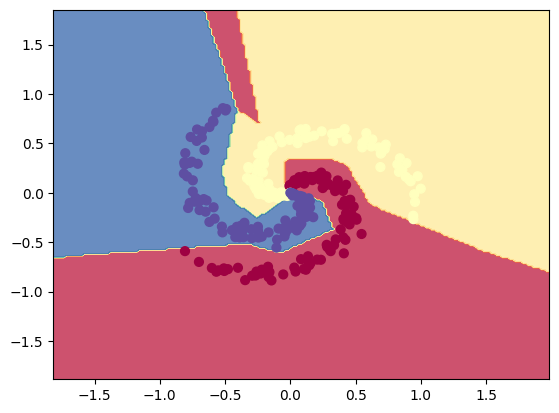

In [12]:
# 1. Generate Data
X, y = generate_spiral_data(N=100, K=3)

# 2. Initialize Model
model = TwoLayerNet(input_dim=2, hidden_dim=100, output_dim=3, activation='relu', lr=1.0)

# 3. Training Loop
print("Training started...")
for i in range(2000):
    loss = model.step(X, y)

    if i % 200 == 0:
        predictions = np.argmax(model.forward(X), axis=1)
        acc = np.mean(predictions == y)
        print(f"Iter {i}: Loss {loss:.4f}, Acc {acc:.2f}")

# 4. Visualize
print("Final Decision Boundary:")
plot_decision_boundary(model, X, y)

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [13]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True,pdf=False)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2 results: All test cases passed!

    q3 results: All test cases passed!

    q4 results: All test cases passed!
